## 2. How do submodular functions work?

So far we've focused on looking at submodular functions in action, primarily in the context of identifying a good selection of samples for the purpose of training machine learning models. While we have covered at a high level how submodular selection works, in this tutorial we will focus on the math and mechanics behind submodular selection.

As mentioned before, submodular selection is a process of greedily selecting objects from a large set of objects in such a manner that a submodular function is maximized. This general definition allows submodular selection to be applied in a wide variety of areas. In our context we'll be focusing on the selection of samples for data analysis or machine learning purpose and using terminology common to that field.

The equation for a feature based function is below.

\begin{equation}
f(X) = \sum\limits_{u \in U} w_{u} \phi_{u} \left( \sum\limits_{x \in X} m_{u}(x) \right)
\end{equation}

In this equation, $U$ refers to all features in a sample, and $u$ refers to a specific feature. $X$ refers to the original data set that we are selecting from and $x$ refers to a single sample from that data set. $w$ is a vector of weights that indicate how important each feature is, with $w_{u}$ being a scalar referring to how important feature $u$ is. Frequently these weights are uniform. $\phi$ refers to a set of saturating functions, such as $sqrt(X)$ or $log(X + 1)$ that incude a property of "diminishing returns" on the feature values. These diminishing returns will become very important later.

When we maximize a submodular function, our goal is to, for each iteration, select the sample that yields the largest gain when added to the growing subset. This gain is dependant on the items that are already in the subset due to the saturating function. Let's talk through an example of selecting the best subset.

In [113]:
%pylab inline
import seaborn; seaborn.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


Let's generate a two dimensional data set for the purposes of vissualization, where some samples are high in one of the features and some samples are high in the other feature. We do this purposefully so as to illustrate the effect that selection has on the marginal gain of each sample during the selection process.

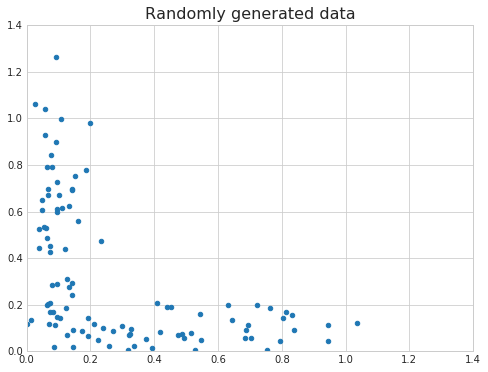

In [128]:
numpy.random.seed(3)
X = numpy.concatenate([numpy.random.normal([0.5, 0.1], [0.3, 0.05], size=(50, 2)),
                       numpy.random.normal([0.1, 0.5], [0.05, 0.4], size=(50, 2))])
X = numpy.abs(X)

plt.figure(figsize=(8, 6))
plt.title("Randomly generated data", fontsize=16)
plt.scatter(X[:,0], X[:,1], s=20)
plt.xlim(0, 1.4)
plt.ylim(0, 1.4)
plt.show()

Now let's implement a function that calculates the gain of each sample with respect to some growing subset. Since we are using a feature based function, the gain requires summing column-wise down each sample in the growing set and then applying the saturating function in order to squash it. We can speed this up significantly by pre-computing the column-wise sums of the current selected set, so that we only need to add in the new sample to be considered.

In [129]:
def gains(X, z=None):
    concave_sums = numpy.sum(z, axis=0) if z is not None else numpy.zeros(X.shape[1])
    concave_func = numpy.log(concave_sums + 1)
    gains = []
    
    for x in X:
        gain = numpy.sum(numpy.log(concave_sums + x + 1) - concave_func).sum()
        gains.append(gain)
    
    return gains

We can now use this function in order to calculate the gain of each of the samples in our set if we were to use it as the first sample in our subset.

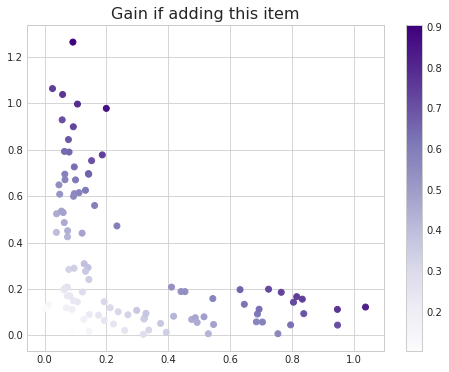

In [132]:
gain1 = gains(X)

plt.figure(figsize=(8, 6))
plt.title("Gain if adding this item", fontsize=16)
plt.scatter(X[:,0], X[:,1], c=gain1, cmap='Purples')
plt.colorbar()
plt.show()

We see a clear trend that the samples with high values in either of the two dimensions have high gains, whereas those samples with small values in each dimension have small gains. Given the simplicity of the feature-based selection algorithm this makes sense---high feature values correspond to higher gains. 

What happens if we select the sample with the highest gain and then recalculate gains?

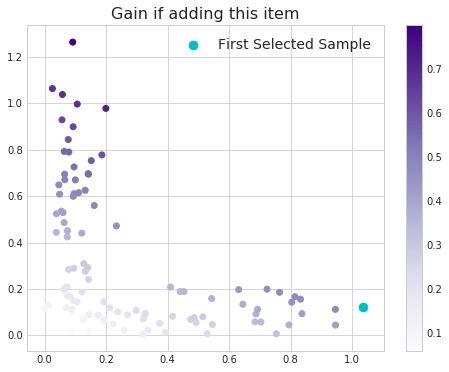

In [134]:
idx = numpy.argmax(gain)
z = [X[idx]]

gain2 = gains(X, z)

plt.figure(figsize=(8, 6))
plt.title("Gain if adding this item", fontsize=16)
plt.scatter(X[:,0], X[:,1], c=gain2, cmap='Purples')
plt.colorbar()

plt.scatter(X[idx, 0], X[idx, 1], c='c', s=75, label="First Selected Sample")
plt.legend(fontsize=14)
plt.show()

It looks like we select a sample that has the highest magnitude single feature value. While the saturating function will flatten values as the set gets larger, with small feature values and no samples in the subset yet, the raw feature value is roughly the gain. 

Interestingly, it looks like all of the samples that have higher values for the y-axis now have a diminished marginal gain. The highest gain samples now look like they come from those with high x-axis values. 

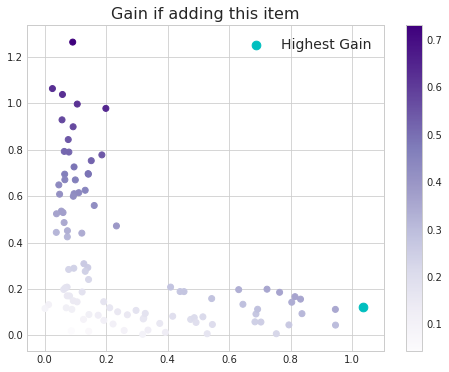

In [135]:
idx = numpy.argmax(gain)
z += [X[idx]]


gain3 = gains(X, z)

plt.figure(figsize=(8, 6))
plt.title("Gain if adding this item", fontsize=16)
plt.scatter(X[:,0], X[:,1], c=gain3, cmap='Purples')
plt.colorbar()

plt.scatter(X[idx, 0], X[idx, 1], c='c', s=75, label="Highest Gain")
plt.legend(fontsize=14)
plt.show()

To complete the selection process, we would greedily select samples from the full set until the desired number of samples have been reached. This requires scanning over the full set (minus the samples that have been selected) one full time for each samle that we would like to select, coting $nm$ time where $n$ is the number of samples in the full set and $m$ is the number of samples that onne would like to select. Because sometimes our goal is to induce a ranking over the full set, i.e., dtermine the order of selection for each sample, this becomes quadratic time.

Is it possible to do better than than this? The short answer is yes, and the reason lies in non-negativity constraint on the input data and on the saturating function. 

In [138]:
import pandas

gain_table = pandas.DataFrame({"x" : X[:,0], "y" : X[:,1], "gain 1": gain1, "gain 2": gain2, "gain 3": gain3})
gain_table[['x', 'y', 'gain 1', 'gain 2', 'gain 3']].head()

,x,y,gain 1,gain 2,gain 3
0,1.036589,0.121825,0.826233,0.514530,0.384106
1,0.528949,0.006825,0.431383,0.236958,0.164286
2,0.416784,0.082262,0.427443,0.256952,0.191228
3,0.475178,0.068650,0.455174,0.269106,0.197503
4,0.486855,0.076139,0.470043,0.280015,0.206479


We can exploit the property of diminishing returns to devise a better algorithm for selection known as the "lazy greedy" algorithm. This algorithm relies on the property that each time a sample is added to the growing set, the gains of each other sample diminish.

The algorithm works faily simply. First, a priority queue is built consisting of the samples prioritized by their gain, with the sample with the highest gain at the front. That sample is then selected for addition to the growing subset. After this selection, the gain values for each sample will be different. However, due to this monotonic decrease in gain, should the sample that was second in line at the time of selection remain at the front of the queue after that first element was selected and the sample was r-evaluated, it would be at the front of the queue even if all items were evaluated. It can be selected without needing to re-evaluate all other samples.

In [168]:
def select(X, k=10):
    z = []
    idxs = numpy.zeros(X.shape[0], dtype=bool)
    
    concave_sums = numpy.zeros(X.shape[1])
    concave_func = numpy.zeros(X.shape[1])
    
    for i in range(k):
        best_gain, best_sample, best_idx = 0, None, -1
        
        for j, x in enumerate(X):
            if idxs[j] == True:
                continue
                
            gain = numpy.sum(numpy.log(concave_sums + x + 1) - concave_func)
            
            if gain > best_gain:
                best_idx, best_gain, best_sample = j, gain, x
        
        z.append(best_sample)
        idxs[best_idx] = True
        
        concave_sums += best_sample
        concave_func = numpy.log(concave_sums + 1)
    
    return numpy.array(z)

In [211]:
from joblib import Parallel, delayed

def subselect(X, concave_sums, concave_func, idxs):
    best_idx, best_gain, best_sample = None, 0, None
    
    for j, x in enumerate(X):
        if idxs[j] == True:
            continue

        gain = numpy.sum(numpy.log(concave_sums + x + 1) - concave_func)

        if gain > best_gain:
            best_idx, best_gain, best_sample = j, gain, x

    return best_idx, best_gain, best_sample

def parallel_select(X, k=10, n_jobs=1):
    z = []
    idxs = numpy.zeros(X.shape[0], dtype=bool)
    
    concave_sums = numpy.zeros(X.shape[1])
    concave_func = numpy.zeros(X.shape[1])
    
    func = delayed(subselect)
    with Parallel(n_jobs=n_jobs) as parallel:
        for _ in range(k):
            results = parallel(func(X[i::n_jobs], concave_sums, concave_func, idxs) for i in range(n_jobs))

            best_idx, best_gain, best_sample = None, 0, None
            for idx, gain, sample in results:
                if gain > best_gain:
                    best_idx, best_gain, best_sample = idx, gain, sample

            concave_sums += best_sample
            concave_func = numpy.log(concave_sums + 1)

            z.append(best_sample)
        
    return numpy.array(z)

In [209]:
X = numpy.random.normal(10, 1, size=(100000, 300))

In [210]:
%timeit -n 1 -r 1 select(X, 10)
%timeit -n 1 -r 1 parallel_select(X, 10)
%timeit -n 1 -r 1 parallel_select(X, 10, 2)

1 loop, best of 1: 13.8 s per loop
1 loop, best of 1: 13.9 s per loop
1 loop, best of 1: 20.8 s per loop
